In [2]:
import pandas as pd
import os
import numpy as np
from pylab import *
from PIL import Image, ImageChops, ImageEnhance
from keras.models import load_model
from keras.utils.np_utils import to_categorical
from keras.preprocessing import image

# from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import itertools
import pickle

Using TensorFlow backend.


In [3]:
def convert_to_ela_image(path, quality):
    filename = path
    resaved_filename = filename.split('.')[0] + '.resaved.jpg'
    ELA_filename = filename.split('.')[0] + '.ela.png'
    
    im = Image.open(filename).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality=quality)
    resaved_im = Image.open(resaved_filename)
    
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    
    return ela_im

In [4]:
# model = load_model('saved-models/model-v1-with-casia.h5')
model = load_model('saved-models/model-v2-with-mixed-dataset.h5')

In [5]:
dataset = pd.read_csv('datasets/dataset-v2/real_and_fake_face/real-fake-dataset.csv')

In [6]:
X = []
Y = []

In [7]:
count = 0
for index, row in dataset.iterrows():
    if count == 10000:
        break
    if os.path.isfile(row[0]):
        X.append(array(convert_to_ela_image(row[0], 10).resize((128, 128))).flatten() / 255.0)
        Y.append(row[1])
        count += 1
        print('done: '+str(count))
print("==== FINISHED ====")

done: 1
done: 2
done: 3
done: 4
done: 5
done: 6
done: 7
done: 8
done: 9
done: 10
done: 11
done: 12
done: 13
done: 14
done: 15
done: 16
done: 17
done: 18
done: 19
done: 20
done: 21
done: 22
done: 23
done: 24
done: 25
done: 26
done: 27
done: 28
done: 29
done: 30
done: 31
done: 32
done: 33
done: 34
done: 35
done: 36
done: 37
done: 38
done: 39
done: 40
done: 41
done: 42
done: 43
done: 44
done: 45
done: 46
done: 47
done: 48
done: 49
done: 50
done: 51
done: 52
done: 53
done: 54
done: 55
done: 56
done: 57
done: 58
done: 59
done: 60
done: 61
done: 62
done: 63
done: 64
done: 65
done: 66
done: 67
done: 68
done: 69
done: 70
done: 71
done: 72
done: 73
done: 74
done: 75
done: 76
done: 77
done: 78
done: 79
done: 80
done: 81
done: 82
done: 83
done: 84
done: 85
done: 86
done: 87
done: 88
done: 89
done: 90
done: 91
done: 92
done: 93
done: 94
done: 95
done: 96
done: 97
done: 98
done: 99
done: 100
done: 101
done: 102
done: 103
done: 104
done: 105
done: 106
done: 107
done: 108
done: 109
done: 110
done: 11

In [8]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [40]:
# ## Dump data to pickle
# output = open('X_data.pkl', 'wb')
# pickle.dump(X, output)
# output.close()
# output = open('Y_data.pkl', 'wb')
# pickle.dump(Y, output)
# output.close()

In [9]:
# X_pkl_file = open('datasets/X_data.pkl', 'rb')
# X = pickle.load(X_pkl_file)
# Y_pkl_file = open('datasets/Y_data.pkl', 'rb')
# Y = pickle.load(Y_pkl_file)

In [13]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.9, random_state=5)

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### MODEL V1 PREDICT DATASET V2

3220/3220 [==============================] - 30s 9ms/step


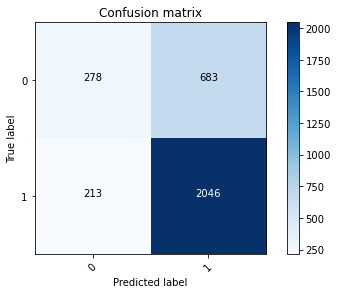

In [66]:
Y_pred = model.predict(X_val, verbose=1)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

### MODEL V1 ROC CURVE

In [67]:
y_pred_proba = model.predict_proba(X_val, verbose=1)

3220/3220 [==============================] - 30s 9ms/step


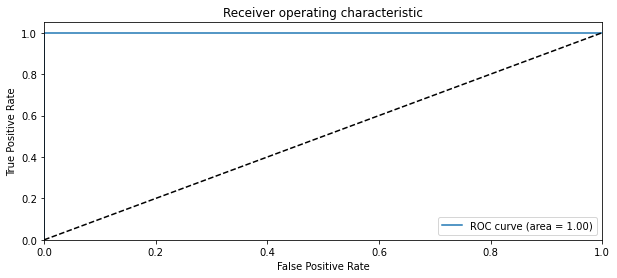

In [68]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_pred_classes, y_pred_proba[:,1])
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(figsize=(10,4))
plt.plot(fpr_keras, tpr_keras, label='ROC curve (area = %0.2f)' % (auc_keras))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [69]:
fpr_keras

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [70]:
tpr_keras

array([0.        , 0.00256504, 0.00329791, 0.00476365, 0.00549652,
       0.00586295, 0.00696226, 0.008428  , 0.00879443, 0.0095273 ,
       0.0106266 , 0.01172591, 0.01355808, 0.01429095, 0.02052034,
       0.02125321, 0.02638329, 0.02711616, 0.03297911, 0.03407842,
       0.03627702, 0.03700989, 0.04250641, 0.04323928, 0.05972884,
       0.06046171, 0.06082814, 0.06156101, 0.06815683, 0.0688897 ,
       0.06925614, 0.06998901, 0.08281422, 0.08354709, 0.2128985 ,
       0.21363137, 0.26749725, 0.26823012, 0.27042873, 0.2711616 ,
       0.27849029, 0.27922316, 0.39281788, 0.39355075, 0.6397948 ,
       0.64052767, 1.        , 1.        ])

In [71]:
thresholds_keras

array([2.0000000e+00, 1.0000000e+00, 9.9999988e-01, 9.9999976e-01,
       9.9999964e-01, 9.9999952e-01, 9.9999940e-01, 9.9999917e-01,
       9.9999893e-01, 9.9999881e-01, 9.9999821e-01, 9.9999809e-01,
       9.9999690e-01, 9.9999678e-01, 9.9999094e-01, 9.9999082e-01,
       9.9998212e-01, 9.9998176e-01, 9.9996805e-01, 9.9996758e-01,
       9.9996257e-01, 9.9996054e-01, 9.9994755e-01, 9.9994707e-01,
       9.9989665e-01, 9.9989450e-01, 9.9989271e-01, 9.9989152e-01,
       9.9986315e-01, 9.9985969e-01, 9.9985945e-01, 9.9985862e-01,
       9.9979955e-01, 9.9979919e-01, 9.9860805e-01, 9.9858898e-01,
       9.9724317e-01, 9.9724209e-01, 9.9720347e-01, 9.9720192e-01,
       9.9699700e-01, 9.9698919e-01, 9.9226236e-01, 9.9220312e-01,
       9.5790523e-01, 9.5759696e-01, 5.0008589e-01, 9.3791286e-08],
      dtype=float32)

In [72]:
print("Model V1 Accuracy: {} %".format(accuracy_score(Y_val[:,1], Y_pred_classes) * 100))
print("Model V1 Precision: {} %".format(precision_score(Y_val[:,1], Y_pred_classes) * 100))
print("Model V1 Recall: {} %".format(recall_score(Y_val[:,1], Y_pred_classes) * 100))
print("Model V1 F1-score: {} %".format(f1_score(Y_val[:,1], Y_pred_classes) * 100))

Model V1 Accuracy: 72.17391304347827 %
Model V1 Precision: 74.97251740564309 %
Model V1 Recall: 90.57104913678619 %
Model V1 F1-score: 82.03688853247795 %


### MODEL V2 PREDICT DATASET V2

3220/3220 [==============================] - 32s 10ms/step


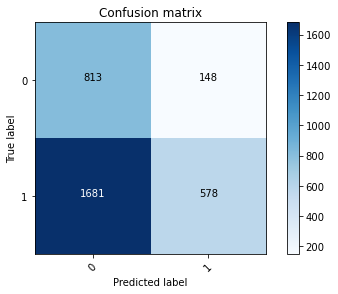

In [14]:
Y_pred = model.predict(X_val, verbose=1)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

### MODEL V2 ROC CURVE

In [59]:
y_pred_proba = model.predict_proba(X_val, verbose=1)

3220/3220 [==============================] - 30s 9ms/step


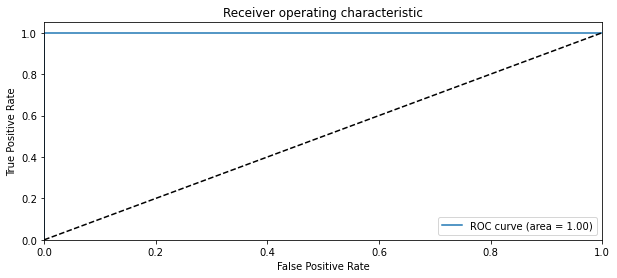

In [36]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_pred_classes, y_pred_proba[:,1])
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(figsize=(10,4))
plt.plot(fpr_keras, tpr_keras, label='ROC curve (area = %0.2f)' % (auc_keras))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [60]:
fpr_keras

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1.])

In [61]:
tpr_keras

array([0.        , 0.42784693, 0.44536653, 0.45550945, 0.461503  ,
       0.46334716, 0.46795758, 0.47118488, 0.472568  , 0.47487321,
       0.47625634, 0.47856155, 0.47948363, 0.48317197, 0.48547718,
       0.48639926, 0.48778239, 0.49054864, 0.49100968, 0.49193177,
       0.49239281, 0.49331489, 0.49377593, 0.4956201 , 0.49700323,
       0.4988474 , 0.49930844, 0.50069156, 0.50161365, 0.50299677,
       0.50391886, 0.5043799 , 0.50622407, 0.50668511, 0.50806823,
       0.50945136, 0.51129553, 0.51221761, 0.5131397 , 0.51452282,
       0.51590595, 0.51682803, 0.51821116, 0.51913324, 0.52282158,
       0.52374366, 0.54817888, 0.54910097, 0.62932227, 0.63024435,
       0.6330106 , 0.63393269, 1.        , 1.        ])

In [62]:
thresholds_keras

array([2.0000000e+00, 1.0000000e+00, 9.9999988e-01, 9.9999964e-01,
       9.9999952e-01, 9.9999940e-01, 9.9999928e-01, 9.9999917e-01,
       9.9999905e-01, 9.9999893e-01, 9.9999881e-01, 9.9999857e-01,
       9.9999845e-01, 9.9999821e-01, 9.9999809e-01, 9.9999797e-01,
       9.9999785e-01, 9.9999774e-01, 9.9999762e-01, 9.9999750e-01,
       9.9999738e-01, 9.9999726e-01, 9.9999714e-01, 9.9999666e-01,
       9.9999630e-01, 9.9999607e-01, 9.9999595e-01, 9.9999583e-01,
       9.9999559e-01, 9.9999547e-01, 9.9999523e-01, 9.9999499e-01,
       9.9999475e-01, 9.9999464e-01, 9.9999452e-01, 9.9999380e-01,
       9.9999368e-01, 9.9999356e-01, 9.9999273e-01, 9.9999261e-01,
       9.9999154e-01, 9.9999130e-01, 9.9999058e-01, 9.9998999e-01,
       9.9998581e-01, 9.9998522e-01, 9.9995029e-01, 9.9994707e-01,
       9.9889994e-01, 9.9887866e-01, 9.9882275e-01, 9.9881494e-01,
       5.0101334e-01, 2.0023032e-05], dtype=float32)

In [63]:
print("Model V2 Accuracy: {} %".format(accuracy_score(Y_val[:,1], Y_pred_classes) * 100))
print("Model V2 Precision: {} %".format(precision_score(Y_val[:,1], Y_pred_classes) * 100))
print("Model V2 Recall: {} %".format(recall_score(Y_val[:,1], Y_pred_classes) * 100))
print("Model V2 F1-score: {} %".format(f1_score(Y_val[:,1], Y_pred_classes) * 100))

Model V2 Accuracy: 88.4472049689441 %
Model V2 Precision: 95.73436742607852 %
Model V2 Recall: 87.42806551571492 %
Model V2 F1-score: 91.3928736695974 %


### MODEL V3 PREDICT DATASET V2

3220/3220 [==============================] - 29s 9ms/step


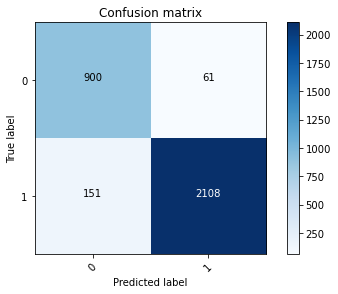

In [39]:
#  (clf.predict_proba(X_test)[:,1] >= 0.7367280663362746)
Y_pred = model.predict(X_val, verbose=1)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(array(Y_val),axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# # plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

### MODEL V3 ROC CURVE

In [45]:
y_pred_proba = model.predict_proba(X_val, verbose=1)

3220/3220 [==============================] - 29s 9ms/step


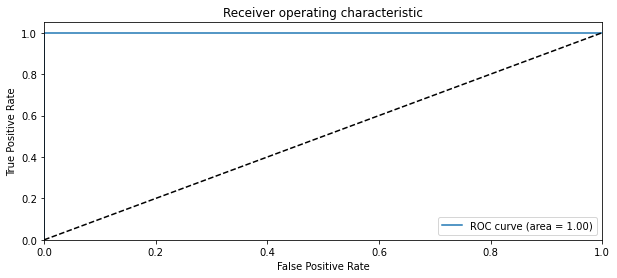

In [54]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_pred_classes, y_pred_proba[:,1])
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(figsize=(10,4))
plt.plot(fpr_keras, tpr_keras, label='ROC curve (area = %0.2f)' % (auc_keras))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [55]:
fpr_keras

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1.])

In [56]:
tpr_keras

array([0.        , 0.42784693, 0.44536653, 0.45550945, 0.461503  ,
       0.46334716, 0.46795758, 0.47118488, 0.472568  , 0.47487321,
       0.47625634, 0.47856155, 0.47948363, 0.48317197, 0.48547718,
       0.48639926, 0.48778239, 0.49054864, 0.49100968, 0.49193177,
       0.49239281, 0.49331489, 0.49377593, 0.4956201 , 0.49700323,
       0.4988474 , 0.49930844, 0.50069156, 0.50161365, 0.50299677,
       0.50391886, 0.5043799 , 0.50622407, 0.50668511, 0.50806823,
       0.50945136, 0.51129553, 0.51221761, 0.5131397 , 0.51452282,
       0.51590595, 0.51682803, 0.51821116, 0.51913324, 0.52282158,
       0.52374366, 0.54817888, 0.54910097, 0.62932227, 0.63024435,
       0.6330106 , 0.63393269, 1.        , 1.        ])

In [43]:
thresholds_keras

array([2.00000000e+00, 1.00000000e+00, 9.99999881e-01, 9.99999762e-01,
       9.99999523e-01, 9.99999166e-01, 9.99999046e-01, 9.99998808e-01,
       9.99998689e-01, 9.99998212e-01, 9.99998093e-01, 9.99997973e-01,
       9.99997854e-01, 9.99997139e-01, 9.99996662e-01, 9.99996185e-01,
       9.99992490e-01, 9.99992013e-01, 9.99990582e-01, 9.99989748e-01,
       9.99989033e-01, 9.99988556e-01, 9.99970794e-01, 9.99970675e-01,
       9.99940276e-01, 9.99939442e-01, 9.99915242e-01, 9.99912977e-01,
       9.99910474e-01, 9.99907732e-01, 9.99887228e-01, 9.99887109e-01,
       9.99515176e-01, 9.99514580e-01, 9.98861432e-01, 9.98856783e-01,
       9.98214841e-01, 9.98187721e-01, 9.96179461e-01, 9.96148467e-01,
       9.95201468e-01, 9.95189309e-01, 9.94516194e-01, 9.94431794e-01,
       9.93568778e-01, 9.93507266e-01, 9.82921541e-01, 9.82842028e-01,
       9.77625191e-01, 9.77532268e-01, 9.73852217e-01, 9.73527968e-01,
       9.68306065e-01, 9.68189538e-01, 9.65596735e-01, 9.65467453e-01,
      

### MODEL V3 OTHER METRICS

In [53]:
print("Model V3 Accuracy: {} %".format(accuracy_score(Y_val[:,1], Y_pred_classes) * 100))
print("Model V3 Precision: {} %".format(precision_score(Y_val[:,1], Y_pred_classes) * 100))
print("Model V3 Recall: {} %".format(recall_score(Y_val[:,1], Y_pred_classes) * 100))
print("Model V3 F1-score: {} %".format(f1_score(Y_val[:,1], Y_pred_classes) * 100))

Model V3 Accuracy: 93.41614906832298 %
Model V3 Precision: 97.18764407561088 %
Model V3 Recall: 93.31562638335546 %
Model V3 F1-score: 95.2122854561879 %


### MODEL V4 PREDICT DATASET V2

3220/3220 [==============================] - 40s 12ms/step


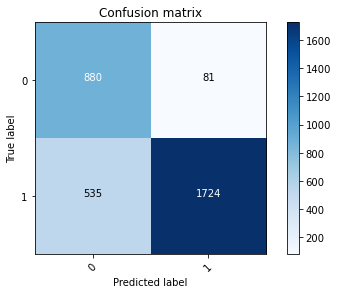

In [12]:
#  (clf.predict_proba(X_test)[:,1] >= 0.7367280663362746)
Y_pred = model.predict(X_val, verbose=1)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(array(Y_val),axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# # plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

### MODEL V4 ROC CURVE

In [13]:
y_pred_proba = model.predict_proba(X_val, verbose=1)

3220/3220 [==============================] - 40s 12ms/step


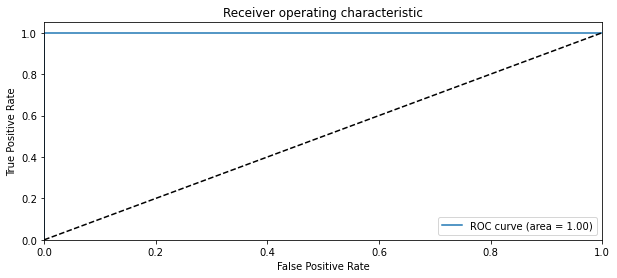

In [14]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_pred_classes, y_pred_proba[:,1])
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(figsize=(10,4))
plt.plot(fpr_keras, tpr_keras, label='ROC curve (area = %0.2f)' % (auc_keras))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

### MODEL V3 OTHER METRICS

In [15]:
print("Model V3 Accuracy: {} %".format(accuracy_score(Y_val[:,1], Y_pred_classes) * 100))
print("Model V3 Precision: {} %".format(precision_score(Y_val[:,1], Y_pred_classes) * 100))
print("Model V3 Recall: {} %".format(recall_score(Y_val[:,1], Y_pred_classes) * 100))
print("Model V3 F1-score: {} %".format(f1_score(Y_val[:,1], Y_pred_classes) * 100))

Model V3 Accuracy: 80.8695652173913 %
Model V3 Precision: 95.51246537396122 %
Model V3 Recall: 76.3169544046038 %
Model V3 F1-score: 84.84251968503938 %
